# Téma 1: Úvod do problematiky, exponenciální vyhlazování

In [39]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pylab as plt
import statsmodels as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

np.set_printoptions(precision=3)

> **Definice**
>
> Časová řada je soubor pozorování (označených např. $x_t$) získaných v konkrétních časových okamžicích $t$.

> *Maličko přesněji: Buď $(\Omega, \mathcal{F}, P)$ pravděpodobnostní prostor a $T$ množina indexů interpretovaných jako čas. Časovou řadou nazýváme množinu $\{X_t, t\in T\}$, kde $X_t$ jsou náhodné veličiny z $(\Omega, \mathcal{F}, P)$.*

Je-li $t\in \mathbb{Z}$, mluvíme o časové řadě (náhodném procesu) s diskrétním časem. Naopak, je-li $t\in\mathbb{R}$, jde o řadu (proces) se spojitým časem. Samozřejmě se můžeme omezit jen na nezáporné indexy apod.

Veličiny $X_t$ mohou být rovněž z množiny reálných čísel, přirozených čísel atd. V našem předmětu se budeme prakticky výhradně zabývat reálnými časovými řadami s diskrétním časem.

## Příklady časových řad
Časové řady, resp. data měřená v pevných či proměnných časových okamžicích, se vyskytují v naprosté většině odvětví. Níže si představíme pár příkladů.

![BWPI](img/l1-beveridge-wheat-price-index-150.png)
![OP](img/l1-oil-prices-in-constant-1997-doll.png)

![ECB](img/ecb-czk-eur.png)

### Fyzikální časové řady
Časové řady ve fyzice, geofyzice, meteorologii atd. Vznikají jako posloupnost měření určitého fenoménu za účelem jeho další analýzy.
![SSPOT](img/l1-yearly-mean-total-sunspot-number.png)
![TEMP](img/l1-longterm-monthly-temperature-s.png)

### ...a již ne tolik populární COVID-19 data

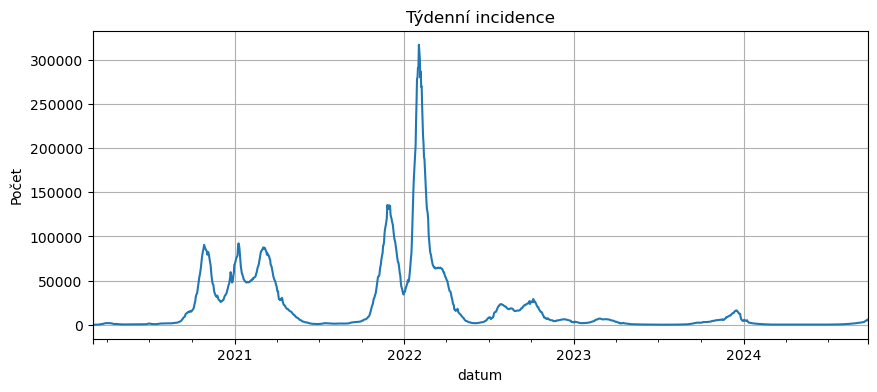

In [19]:
fn = 'data/incidence-7-14-2024.csv'
data_covid = pd.read_csv(fn, index_col='datum', parse_dates=True)
data_covid = data_covid.asfreq('D')
data_covid['incidence_7'].plot(figsize=(10,4))
plt.title('Týdenní incidence')
plt.ylabel('Počet')
plt.show()

## Cíle analýzy časových řad
1. **Popis pozorovaného jevu** - velmi často je cílem pouze vysledovat vlastnosti pozorovaného systému či procesu, např. rozsah hodnot, periodicita a sezónnost, krátkodobý a dlouhodobý vývoj, přítomnost odlehlých a extrémních hodnot, analýza závislostí mezi několika časovými řadami, resp. měřenými veličinami atd. Analýza je v první fázi často realizována pouhým vykreslením grafu vývoje časové řady a subjektivní vizuální analýzou.

2. **Predikce budoucího vývoje popř. interpolace vývoje minulého**. Tento cíl je potom velmi často spjat rovněž s řízením.

3. **Řízení** - je-li potřeba řídit nějaký proces, např. ve výrobě či epidemiologii, je nezbytné vycházet z měřených dat, která tento proces determinují.

## Vlastnosti časových řad
### Variabilita vývoje
1. **Trend** - obecně definovaný jako *dlouhodobý vývoj střední hodnoty*. Tato definice je ovšem poměrně vágní, protože v dlouhém běhu může časová řada vykazovat *cyklické změny*, které v kratším (avšak stále relativně dlouhém) časovém úseku připisujeme trendu. To se typicky týká klimatických podmínek.
2. [**Sezónnost**](https://en.wikipedia.org/wiki/Seasonality) - periodicky se opakující, poměrně pravidelný a předpověditelný (očekávatelný) vývoj časové řady. Typické jsou například vývoje teploty v průběhu roku, počet zákazníků v pneuservisech, počet zaměstnanců v zemědělství, počet zákazníků v horských centrech apod. Sezónnost můžeme celkem dobře analyzovat v příslušném [grafu sezónnosti](https://en.wikipedia.org/wiki/Seasonal_subseries_plot), či lépe v řadě box plotů, oba vyžadují znalost periody. Tu můžeme zjistit pomocí *autokorelační funkce* (ACF). Pro analýzu sezónnosti je ale vždy potřeba nejprve odstranit *trend*.
3. **Cyklické změny** - fluktuace, které zpravidla nemají pevnou periodu, např. ekonomické cykly.
4. **Další nepravidelné fluktuace**

Podívejme se na populární dataset "Airline passangers":

<Axes: xlabel='Date'>

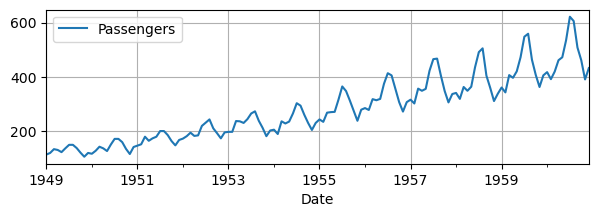

In [70]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_csv('../zdrojaky/international-airline-passengers.csv', header=0, 
                 index_col=0, infer_datetime_format=True, parse_dates=True)
df.plot(figsize=(7,2))

Graf sezónnosti (přes měsíce) vypadá následovně:

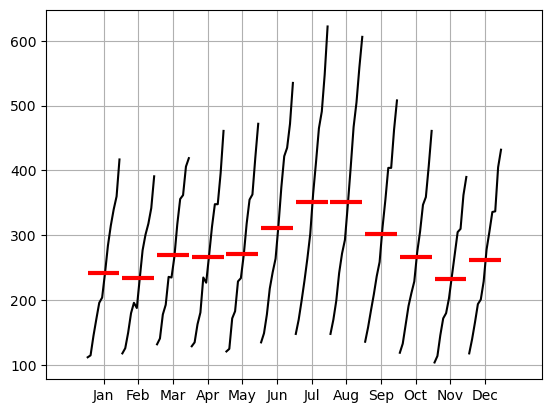

In [75]:
sm.graphics.tsaplots.month_plot(df)
plt.show()

Časovou řadu lze často rozložit na jednotlivé uvedené složky, přičemž cyklické změny a nepravidelné fluktuace se zpravidla sloučí do jedné. Používají se především dva modely:
   - **aditivní**: $Y_t = T_t + S_t + E_t$,
   - **multiplikativní**: $Y_t = T_t \cdot S_t \cdot E_t$,
   
kde $Y_t$ je pozorovaná veličina v čase $t$, $T_t$ je hodnota trendu, $S_t$ je sezónní složka a $E_T$ nevysvětlená složka. V aditivních modelech obecně platí, že amplituda sezónních složek je přibližně stejná, zatímco v multiplikativních se s rostoucím trendem zvyšuje i sezónní amplituda (a naopak). Jedním z možných kritérií, jak vybrat vhodný model, je minimalizovat součet čtverců hodnot autokorelační funkce reziduí $E_t$, neboť ACF nám říká, jaká míra korelace v $E_t$ zbyla.

Od pozorované veličiny lze samozřejmě pro různé aplikace odečítat složku trendu nebo sezónnosti.

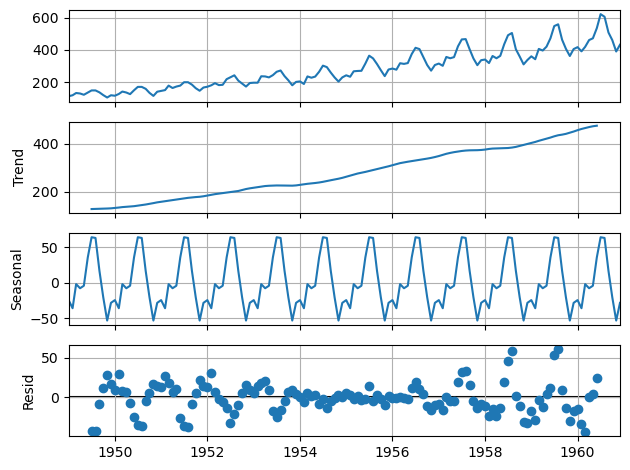

In [78]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_csv('../zdrojaky/international-airline-passengers.csv', header=0, 
                 index_col=0, infer_datetime_format=True, parse_dates=True)

result = seasonal_decompose(df, period=12, model='additive')
result.plot()
plt.show()

Suma kvadrátů reziduí ACF: 1.729


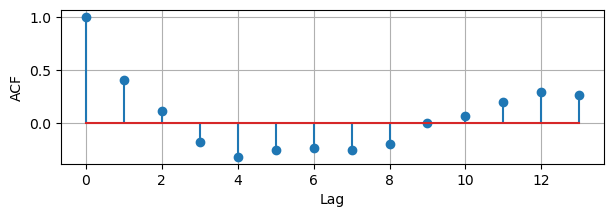

In [77]:
from statsmodels.tsa.stattools import acf
resid_acf = acf(result.resid, nlags=13, missing='drop')
sum_of_squares_resid_acf = np.sum(resid_acf**2)
print(f'Suma kvadrátů reziduí ACF: {sum_of_squares_resid_acf:.3f}')
plt.figure(figsize=(7,2))
plt.stem(resid_acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

**K zamyšlení:**
- jak udělat z multiplikativní řady aditivní?

## Časová řada jako náhodný proces

Zaveďme si, s ohledem na znalosti z teorie pravděpodobnosti, definici náhodného procesu následujícím (neskutečně vágním ;-) způsobem:

> Náhodný proces je posloupnost náhodných veličin $X_t$, kde $t$ je z vhodné množiny indexů.

Z hlediska indexové množiny dělíme náhodné procesy na procesy *diskrétní* či *spojité*, alternativně s diskrétním či spojitým časem. Podle toho je množina indexů buď z oboru celých či přirozených čísel, anebo (celou nebo nezápornou) množinou přirozených čísel. Kdybychom toužili si situaci zkomplikovat, můžeme ovšem uvažovat i jiné množiny.

Z hlediska oboru hodnot $X_t$, někdy též stavového prostoru, mohou být procesy rovněž spojité nebo diskrétní, případně jiné. Navíc mohou být vícerozměrné, např. poloha ve 2D prostoru je dvourozměrná.

Náhodná veličina $X_t$ nabývá pozorované hodnoty $x_t$, tedy $X_t = x_t$. Toto notační pravidlo ale nebudeme striktně dodržovat. Ačkoliv je to matematicky ne zrovna čisté, v inženýrské praxi se mezi náhodnou veličinou a její realizací rozlišuje poměrně zřídka. 

### Momenty
Jednou z možností, jak popisovat časovou řadu, by bylo uvažovat sdruženou distribuci veličin $X_{t_1},\ldots,X_{t_n}$ pro posloupnost indexů $t_1, \ldots, t_n$. To je ovšem v praxi příliš komplikované a namísto toho jsou uvažovány pouze momenty:
- střední hodnota $\mu_t = \mathbb{E}[X_t]$
- variance $\sigma_t^2 = \operatorname{var} X_t$
- autokovariance $\gamma(t_1, t_2) = \operatorname{cov}(X_{t_1}, X_{t_2}) = \mathbb{E}[(X_{t_1} - \mu_{t_1})(X_{t_2} - \mu_{t_2})]$. Eventuálně uvažujeme $\gamma(\tau) = \operatorname{cov}(X_t, X_{t+\tau})$.

Vyšší momenty - centrální i obecné - je rovněž možné uvažovat, avšak v praxi je to řídké.

### Stacionarita
> Říkáme, že časová řada je **striktně (silně) stacionární**, pokud sdružená distribuce $X_{t_1},\ldots, X_{t_n}$ je stejná, jako sdružená distribuce $X_{t_1+\tau},\ldots, X_{t_n+\tau}$ pro všechna $t_1, \ldots, t_n, \tau$.

Definice tedy říká, že posun o libovolný čas $\tau$ nemá vliv na sdruženou distribuci, tj. sdružená distribuční funkce $F_X(\cdot)$ není funkcí času. To znamená, že je stejná pro všechna $t$ a rovněž momenty, např. $\mu = \mu_t$ a $\sigma^2 = \sigma_t^2$ jsou v čase konstantní.


**Příklad:**
 Může se zdát zvláštní, že nějaký proces má mít stejná rozdělení $X_t$ pro všechna $t$. Ve skutečnosti existuje celá řada procesů, které - často bez ohledu na počáteční podmínky - konvergují k limitní distribuci (*equilibrium, stationary distribution*), kde je přesně tento stav splněn.

> Říkáme, že časová řada je **slabě stacionární**, pokud je invariantní vůči posunům v čase pouze v rámci momentů do druhého řádu, tj.
> 
$$\begin{aligned}
\mathbb{E}[X_t] &= \mu,\\
\operatorname{cov}(X_t, X_{t+\tau}) &= \gamma(\tau).
\end{aligned}
$$

Pro většinu budoucí práce v předmětu si vystačíme se slabou stacionaritou.

**K zamyšlení**
- jak se z autokovariance stane variance?
- vyplývá ze striktní stacionarity slabá? Jsou nějaké omezující podmínky (nápověda: Cauchyova distribuce)

## Příklady náhodných procesů

### Bílý šum
[Bílý šum](https://en.wikipedia.org/wiki/White_noise) je náhodný proces $\{X_t\}$, kde

$$
\begin{aligned}
\mathbb{E}[X_t] &= 0, \\
\operatorname{var}(X_t) &= \sigma^2 < \infty,\\
\operatorname{cov}(X_t, X_{t+\tau}) = \gamma(\tau) &= 0.
\end{aligned}
$$

Jde tedy proces, jehož rozdělení má nulovou střední hodnotu (někdy se uvádí pouze *konstantní*), konstantní konečnou varianci a nekorelovanost mezi $X_t$ a $X_{t+\tau}$ pro $\tau > 0$. Jednotlivá $X_t$ jsou nezávislá (proto nekorelovaná) a identicky rozdělená (*iid, independent and identically distributed*).

Speciálním případem je potom normální (gaussovský) bílý šum, kde $X_t \sim \mathcal{N}(0, \sigma^2)$.

Bílý šum má celou řadu praktických využití, např. ve zvukové syntéze, generátorech náhodných čísel aj.

**K zamyšlení**
- jak vypadá hustota normálního bílého šumu pro $[X_t, X_{t+1},\ldots,X_{t+n}]$?
- jak je to se stacionaritou takto definovaného bílého šumu?

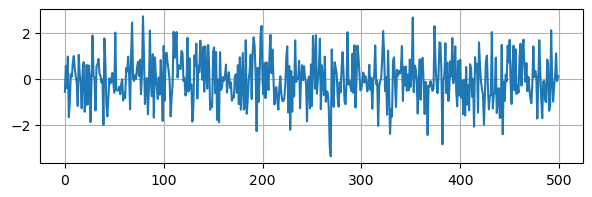

In [79]:
Y = ss.norm.rvs(size=500)
plt.figure(figsize=(7,2))
plt.plot(Y)
plt.show()

### Náhodná procházka
Uvažujme diskrétní bílý šum $Z_t \sim \mathcal{L}(0, \sigma^2)$. Proces $\{X_t\}$ nazýváme [náhodnou procházkou](https://en.wikipedia.org/wiki/Random_walk), pokud
$$
\begin{aligned}
X_0 &= 0,\\
X_t &= X_{t-1} + Z_t,
\end{aligned}
$$

a tedy $X_t = \sum_{i=1}^t Z_t$.

Vidíme, že $\mathbb{E}[X_t] = 0$ a $\operatorname{var}(X_t) = t\sigma^2$.

Náhodná procházka je oblíbeným modelem pro modelování cen akcií, ve fyzice pro popis Brownova pohybu, v computer science pro odhad velikosti webu atd.

**K zamyšlení**
- je náhodná procházka stacionární?
- jsou přírůstky v náhodné procházce stacionární?

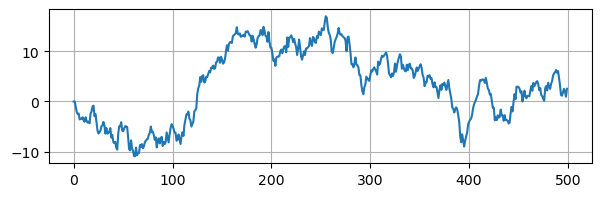

In [102]:
X = np.zeros(500)
for t in range(1, 500):
    X[t] = X[t-1] + ss.norm.rvs()
plt.figure(figsize=(7,2))
plt.plot(X)

### Další procesy
Wienerův proces, poissonovský proces, markovský proces, MA, ARMA, AR... O některých z nich později.

---
---

In [26]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# První modely: Exponenciální vyhlazování (vyrovnávání)

Metody exponenciálního vyhlazování (exponential smoothing) jsou jedny z nejstarších, nejjednodušších a přitom velmi efektivních způsobů práce s časovými řadami. Pomocí nich je možné snadno interpolovat a extrapolovat (predikovat) vývoj řady, které mohou mít různé komponenty, včetně trendu či sezónnosti.

## Jednoduché exponenciální vyhlazování (SES)

SES - simple (či single) exponential smoothing, též Holtova lineární metoda - je základní metodou, která předpokládá **absenci trendu i sezónnosti**. Její princip vychází z následující úvahy, vycházející z dvou extrémních (naivních) přístupů:
- **Extrém 1:** všechna budoucí data (predikce) jsou rovna poslední pozorované hodnotě čas. řady $y_T$:

$$
\hat{y}_{t+h|t} = y_t, \qquad h=1,2,\ldots
$$

- **Extrém 2:** všechny budoucí (predikované) hodnoty jsou rovny aritmetickému průměru dosud pozorovaných hodnot:

$$
\hat{y}_{t+h|t} = \frac{1}{t} \sum_{j=1}^t y_j, \qquad h=1,2,\ldots
$$

První extrém říká, že budoucí pozorování jsou založena na posledním, zatímco druhý extrém zakládá predikci na všech předchozích pozorovaných hodnotách, a to se stejnými váhami $1/t$.

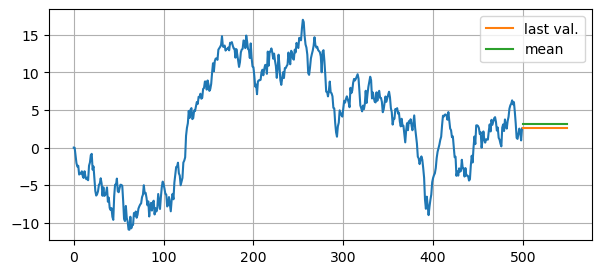

In [104]:
preds_last = X[-1] * np.ones(50)
preds_mean = X.mean() * np.ones(50)
plt.figure(figsize=(7,3))
plt.plot(np.arange(X.size), X)
plt.plot(np.arange(X.size, X.size+preds_last.size), preds_last, label='last val.')
plt.plot(np.arange(X.size, X.size+preds_last.size), preds_mean, label='mean')
plt.legend()
plt.show()

Jednoduché exponenciální vyhlazování potom leží mezi těmito dvěma extrémy - klade větší váhy na novější data a menší váhy na data starší, přičemž vývoj vah je nelineární (exponenciální). Zaveďme průměrovací váhu - vyhlazovací parametr či faktor $\alpha\in[0,1]$ a predikce ve tvaru

$$
\begin{aligned}
\hat{y}_{t+1|t} &= \alpha y_{t} + \alpha(1-\alpha) y_{t-1} + \alpha(1-\alpha)^2 y_{t-2} + \ldots \\
&= \sum_{j=0}^{t} \alpha(1-\alpha)^j y_{t-j},
\end{aligned}
$$

kde $y_0\equiv \hat{y}_0$ je hodnota, již **musíme nějak stanovit či odhadnout**.

Výše uvedený vztah lze zapsat rekurzivně jako vážený průměr poslední hodnoty a její predikce

$$
\hat{y}_{t+1|t} = \alpha y_t + (1-\alpha) \hat{y}_{t|t-1}.
$$

Dosazením vidíme, že

$$
\begin{aligned}
\hat{y}_{2|1} &= \alpha y_1 + (1-\alpha) \hat{y}_{1|0},\\
\hat{y}_{3|2} &= \alpha y_2 + (1-\alpha) \hat{y}_{2|1}\\
              &= \alpha y_2 + (1-\alpha) [\alpha y_1 + (1-\alpha)\hat{y}_{1|0}] \\
              &= \alpha y_2 + \alpha (1-\alpha) y_1 + (1-\alpha)^2\hat{y}_{1|0},\\
              &\vdots\\
\hat{y}_{t+1|t} &=  \sum_{j=0}^{t} \alpha(1-\alpha)^j y_{t-j}.
\end{aligned}
$$

Následující tabulka ukazuje hodnoty vah pro `maxdelay` zpoždění:

In [28]:
alphas = np.array([[.2, .4, .6, .8, 1.]])
weights = alphas.copy()
max_delay = 6
index = ['y(t-0)']
title = []
for j in range(1, max_delay+1):
    weights = np.r_[weights, alphas*(1-alphas)**j]
    index.append(f'y(t-{j})')
for alpha in alphas.flatten():
    title.append(f'alpha={alpha}')
weights_df = pd.DataFrame(weights, columns=title, index=index)
weights_df

,alpha=0.2,alpha=0.4,alpha=0.6,alpha=0.8,alpha=1.0
y(t-0),0.200000,0.400000,0.600000,0.800000,1.0
y(t-1),0.160000,0.240000,0.240000,0.160000,0.0
y(t-2),0.128000,0.144000,0.096000,0.032000,0.0
y(t-3),0.102400,0.086400,0.038400,0.006400,0.0
y(t-4),0.081920,0.051840,0.015360,0.001280,0.0
y(t-5),0.065536,0.031104,0.006144,0.000256,0.0
y(t-6),0.052429,0.018662,0.002458,0.000051,0.0


### Komponentní forma

Namísto zápisu predikcí $\hat{y}_{t+h|t}$ ve formě vážených průměrů se častěji využívá zápis komponentní. Ten je totiž flexibilnější, umožní snadnější vložení dalších komponent jako trendu či sezónnosti.

Označme aktuální "hladinu" - **level** $l_t$. Komponentní model má tvar

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t, \\
\text{Smoothing eq.}&&\qquad l_t &= \alpha y_t + (1 - \alpha) l_{t-1}.
\end{alignat}
$$

Nastavením $h=1$ dostáváme jednokrokovou předpověď (včetně interpolací). Substitucí $\hat{y}_{t+1|t}$ resp. $\hat{y}_{t|t-1}$ za $l_t$ resp. $l_{t-1}$ dostaneme dříve uvedené vážené průměry. Jde tedy o ekvivalentní zápis. Jeho výhodnost uvidíme ve vícekomponentních modelech.

### Volba $l_0$ a $\alpha$

Existuje celá řada způsobů, jak vhodně zvolit parametry $l_0$ a $\alpha$. Jednou z možností pro volbu $l_0$ je využít historická data, spočítat jejich průměr a použít jej. Podobně lze heuristicky přistoupit k volbě $\alpha$. Matematicky podloženější a spolehlivější je odhadnout tyto hodnoty např. metodou nejmenších čtverců, a sice minimalizací součtu kvadratických chyb predikce

$$
\text{SSE}\, = \sum_{t=1}^T (y_t - \hat{y}_{t|t-1})^2.
$$

Narozdíl od regrese, kde je lineární vztah mezi všemi regresory a regresandy naráz, má exponenciální vyhlazování rekurzivní charakter. Optimalizace tedy není lineární a je potřeba využít vhodných optimalizačních technik (či softwaru).

### Příklad na SES

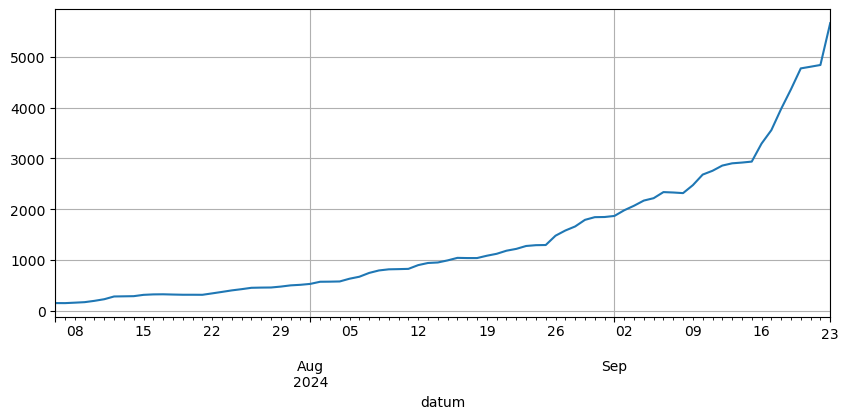

In [105]:
dt = data_covid['incidence_7'].last('80D')
dt.plot(figsize=(10,4))
plt.show()

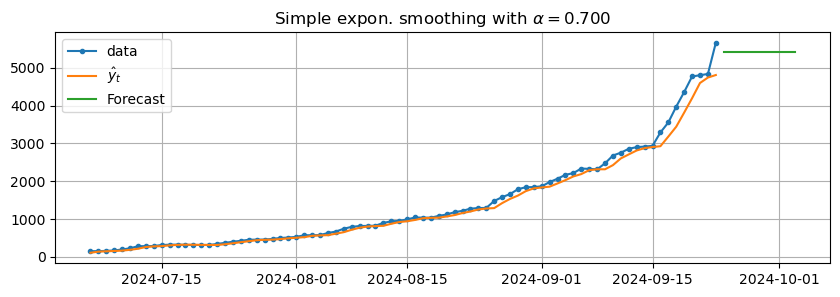

In [109]:
alpha = .7
method = smt.SimpleExpSmoothing(dt, initialization_method="heuristic")
fit = method.fit(smoothing_level=alpha,optimized=False)
#fit = method.fit()
fcast = fit.forecast(10)

plt.figure(figsize=(10, 3))
plt.title(fr"Simple expon. smoothing with $\alpha = {fit.model.params['smoothing_level']:.3f}$")
plt.plot(dt, marker='.', label='data')
plt.plot(fit.fittedvalues, label=r'$\hat{y}_t$')
plt.plot(fcast, label='Forecast')
plt.legend()
plt.show()

## Dvojité exponenciální vyhlazování

Dvojité exponenciální vyhlazování - DES (double ES) - je rozšířením SES na časové řady s trendem. DES metod je větší množství, my si představíme dvě, a to Holtovu metodu s lineárním trendem a metodu s tlumeným trendem.

### Holtova metoda s lineárním trendem

Tato metoda má následující komponentní formu:

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t + hb_t, \\
\text{Level eq.}&&\qquad l_t &= \alpha y_t + (1 - \alpha)(l_{t-1} + b_{t-1}),\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})b_{t-1},
\end{alignat}
$$

kde $l_t$ je level (hladina) časové řady v čase $t$, $b_t$ je odhad směrnice trendu v čase $t$, parametry $\alpha, \beta^* \in [0, 1]$ jsou vyhlazovací paramety. Pozorným čtením rovnic zjistíme, že ono "druhé" vyhlazování běží na trendu (ověřte intuitivně!). Neboli rovnice trendu říká, _jak se změnil level mezi dvěma časovými kroky_.

### Holtova metoda s tlumeným trendem

Jistou nevýhodou této základní metody je invariance trendu, který je buď do nekonečna rostoucí, nebo klesající. Jelikož dlouhodobé předpovědi tohoto modelu mají tendence nadhodnocovat budoucí hodnoty, byl navržen model, který trend utlumuje. Výsledkem je model rozšířený o tlumící parametr $\phi \in(0,1]$, přičemž hodnota $\phi=1$ vede na základní Holtovu metodu s lin. trendem. Komponentní forma modelu je následující:

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t + (\phi + \phi^2 + \cdots + \phi^h) b_t, \\
\text{Level eq.}&&\qquad l_t &= \alpha y_t + (1 - \alpha)(l_{t-1} + \phi b_{t-1}),\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})\phi b_{t-1}.
\end{alignat}
$$

Lze ukázat, že krátkodobé předpovědi mají tlumený trend a dlouhodobé konvergují k netrendovým, tj. konstantním hodnotám $l_T + \phi b_T/(1-\phi)$. V praxi jsou nejčastěji hodnoty $\phi \in [0.8, 0.98]$.

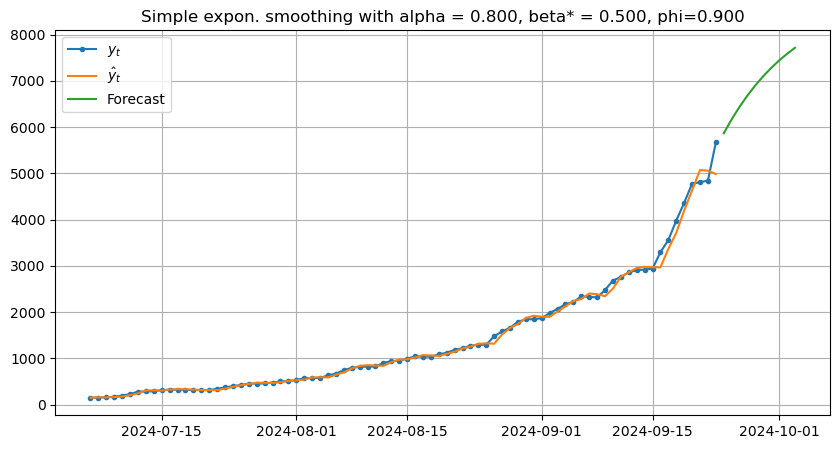

In [112]:
method = smt.ExponentialSmoothing(dt, initialization_method="estimated", 
                                  trend='add', damped_trend=True, seasonal=None)
fit = method.fit(smoothing_level=.8, smoothing_trend=.5, damping_trend=.9, 
                 smoothing_seasonal=None)
# fit = TeamsTeamsTeamsmethod.fit()
fcast = fit.forecast(10)
plt.figure(figsize=(10, 5))
plt.title(f"Simple expon. smoothing with alpha = {fit.model.params['smoothing_level']:.3f}, " 
         + f"beta* = {fit.model.params['smoothing_trend']:.3f}, "
         + f"phi={fit.model.params['damping_trend']:.3f}")
plt.plot(dt, marker='.', label=r'$y_t$')
plt.plot(fit.fittedvalues, label=r'$\hat{y}_t$')
plt.plot(fcast, label='Forecast')
plt.legend()
plt.show()

## Trojité exponenciální vyhlazování (Holtova-Wintersova metoda)

Holtova-Wintersova metoda se sestává ze tří vyhlazovacích rovnic, jedné pro hladinu (level) $l_t$, jedné pro trend $b_t$ a jedné pro sezónní komponentu $s_t$. Ke každé složce potom náleží odpovídající vyhlazovací parametr $\alpha, \beta^*$ a $\gamma$, všechny teoreticky z intervalu $[0, 1]$. Označme písmenem $m$ sezónnost.

Metoda má svou aditivní a multiplikativní variantu, podle toho, zda jsou sezónní variace (typicky amplituda) konstantní, nebo se mění v závislosti na čase.

### Aditivní metoda
Aditivní metoda předpokládá, že sezónní složky jsou prakticky stejné a sčítají se (přibližně) do nuly. Model má tvar

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= l_t + hb_t + s_{t+h-m(k+1)}, \\
\text{Level eq.}&&\qquad l_t &= \alpha (y_t - s_{t-m}) + (1 - \alpha)(l_{t-1} + b_{t-1}),\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})b_{t-1}, \\
\text{Seasonal eq.} &&\qquad s_t &= \gamma(y_t - l_{t-1} - b_{t-1}) + (1-\gamma)s_{t-m},
\end{alignat}
$$

kde $k = \lfloor (h-1)/m \rfloor$. Poslední z rovnic vyjadřuje vážený průměr mezi současnou hodnotou sezónnosti (sezónního indexu) a téže veličinou v předchozí sezóně.

### Multiplikativní metoda
Multiplikativní metoda předpokládá, že sezónní složky se mění v závislost na hladině $l_t$. Sezónní komponenta je v modelu vyjádřena jako relativní (procentuální) veličina, srov. s aditivním modelem. Komponentní forma má tvar

$$
\begin{alignat}{2}
\text{Forecast eq.}&&\qquad \hat{y}_{t+h|t} &= (l_t + hb_t)s_{t+h-m(k+1)}, \\
\text{Level eq.}&&\qquad l_t &= \alpha \frac{y_t}{s_{t-m}} + (1 - \alpha)(l_{t-1} + b_{t-1}),\\
\text{Trend eq.}&&\qquad b_t &= \beta^{*}(l_t - l_{t-1}) + (1 - \beta^{*})b_{t-1}, \\
\text{Seasonal eq.} &&\qquad s_t &= \gamma \frac{y_t}{l_{t-1} + b_{t-1}} + (1-\gamma)s_{t-m}.
\end{alignat}
$$

V rovnici pro hladinu (level) $l_t$ a v sezónní rovnici vidíme zmíněnou relativní hodnotu.

## Literatura

- Exp. vyhlazování
    - R.J. Hyndman & G. Athanasopoulos: [Forecasting: Principles and Practice](https://otexts.com/fpp2/expsmooth.html)
- Náhodné procesy
    - cokoliv matematicky orientovaného